In [240]:
import os
from pathlib import Path

from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ot
import numpy.random as random

In [241]:
def sdf_circle(x, r=0.5):
    return np.sqrt(np.sum(x**2, axis=1)) - r

In [242]:
def sdf_box(x, b=[1.0,1.0]):
    d = np.abs(x)-b
    max_d = np.maximum(d, 0.0)
    length_d = np.sqrt(np.sum(max_d**2, 1))
    return length_d + np.minimum(np.maximum(d[:,0], d[:,1]), 0.0)

In [243]:
def sample_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y = np.meshgrid(idx, idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)

    return V

In [244]:
def linear_morphing(f1, f2, t, x):
    return (1-t)*f1(x) + t*f2(x)

MovieWriter imagemagick unavailable; using Pillow instead.


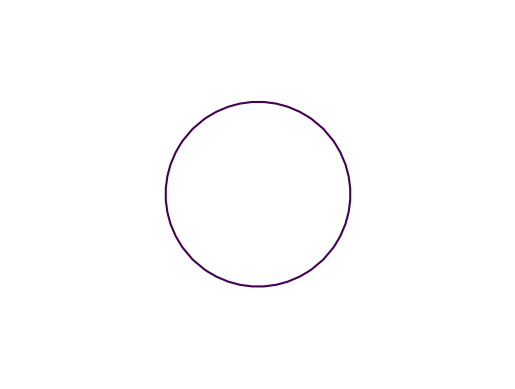

In [245]:
grid_size = 32

fig = plt.figure()
x = sample_grid(grid_size)

def animate(t):
    plt.cla()
    f1=sdf_circle
    f2=sdf_box
    out = linear_morphing(f1, f2,np.array([t]), x)

    
    #levels = np.linspace(-1.0, 1.0, 21)
    #im = plt.contourf(out.reshape(grid_size, grid_size), levels = levels)
    im = plt.contour(out.reshape(grid_size, grid_size), levels = [0.0])
    plt.axis('equal')
    plt.axis("off")
    return im


anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)

anim.save("output.gif", writer="imagemagick")

AssertionError: 

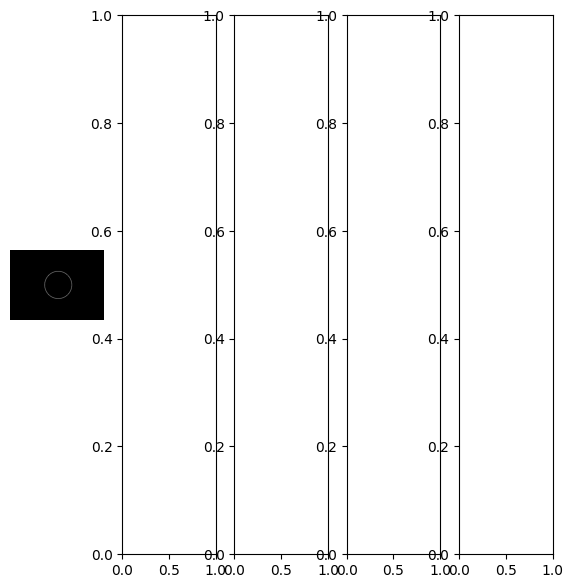

In [246]:
grid_size = 32

gif = cv2.VideoCapture('output.gif') #read gif file

images = [] #insert the images
i = 0
while True:
    is_success, img = gif.read()
    if not is_success:
        break

    images.append(img)
    i += 1

SDF_f=images[0] #SDF images(first shape and last shape) 
SDF_l=images[-2]
cv2.imwrite('first.png',SDF_f)
cv2.imwrite('last.png',SDF_l)

cm = 'gray' #image color
nb_images = 5

f1 = 1 - plt.imread('first.png')[::2, ::2, 2]
f2 = 1 - plt.imread('last.png')[::2, ::2, 2]

f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
A = np.array([f1, f2])

# those are the four corners coordinates that will be interpolated by bilinear interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

fig, axes = plt.subplots(1 ,nb_images, figsize=(7, 7)) #makes 5 images left and right division

reg = 0.004
for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0: 
            axes[i].imshow(f1, cmap=cm)
        elif i == (nb_images - 1):
            axes[i].imshow(f2, cmap=cm)
        else:
            # call to barycenter computation
            axes[i].imshow(
                ot.bregman.convolutional_barycenter2d(A, reg, weights),
                cmap=cm
            )
        axes[i].axis('off')
plt.tight_layout()
plt.show()